In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import json
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import ast

In [2]:
ENV_PARAM = "avg_pm2.5"

In [3]:
PARENT = "../Sweep/"
DATA_FOLDER = PARENT + "data_WESCO/"
DATA_FOLDER_READINGS = DATA_FOLDER + "fixed_readings/"
DATA_FOLDER_CACHE = DATA_FOLDER + 'cache/'
CALIBRATION_FOLDER = DATA_FOLDER + "calibration/"


In [4]:
T = 5

In [5]:
room_names = {
    
}

In [6]:
def import_calibration_models():
    with open(CALIBRATION_FOLDER + 'theater_linear.pkl', 'rb') as file:
        m_t = pickle.load(file)
    with open(CALIBRATION_FOLDER + 'showroom_linear.pkl', 'rb') as file:
        m_s = pickle.load(file)
    with open(CALIBRATION_FOLDER + 'davinci_linear.pkl', 'rb') as file:
        m_v = pickle.load(file)

    return m_t, m_s, m_v

In [7]:
#m_t, m_s, m_v = import_calibration_models()
m_t, m_s, m_v = None, None, None

In [8]:
def import_df_from_json(filename, model):
    with open(filename, "r") as file:
        raw_data = json.load(file)

        device_id = raw_data[0]["payload"]["device_id"]
        device_loc = raw_data[0]["payload"]["device_location"]
        room_names[device_id] = device_loc

    
        dataset = [record["payload"]["data"] for record in raw_data if "data" in record["payload"]]
        df = pd.DataFrame(dataset)

        df['timestamp'] = pd.to_datetime(df['timestamp'].astype(int) // 1000, unit='s')
        #df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df = df.drop_duplicates(subset='timestamp')        
        df["device_id"] = device_id
        df["device_location"] = device_loc

        # calibrate
        if model: # no negative results due to miscalibration
            df["avg_pm2.5"] = [max(model.predict(np.array([[x]]))[0], 0) for x in df["avg_pm2.5"]]


    return df    


In [9]:
df1 = import_df_from_json(DATA_FOLDER_READINGS + "theater.json", m_t)
df2 = import_df_from_json(DATA_FOLDER_READINGS + "davinci.json", m_v)
df3 = import_df_from_json(DATA_FOLDER_READINGS + "showroom.json", m_s)
df4 = import_df_from_json(DATA_FOLDER_READINGS + "metcalfe.json", None)


print(f"{df1.shape=} {df2.shape=} {df3.shape=} {df4.shape=}")


df1.shape=(8661, 14) df2.shape=(7048, 14) df3.shape=(6220, 14) df4.shape=(9073, 14)


In [10]:
#FILTER OUT TMS OF VISIT DAYS
all_tms = set(df1['timestamp']) | set(df2['timestamp']) | set(df3['timestamp']) | set(df4['timestamp'])
all_tms = {ts for ts in all_tms if ts.date() in {pd.Timestamp('2024-07-22'), pd.Timestamp('2024-07-26').date(), pd.Timestamp('2024-07-29').date()}}
# intersection = set(df1['timestamp']) & set(df2['timestamp']) & set(df3['timestamp']) & set(df4['timestamp'])
# print(len(intersection))

In [11]:
def forward_fill_time_limited(df, time_column='timestamp', max_time_diff='60min'):

    F = 0
    filled_df = df.copy()
    
    # Ensure the time column is in datetime format
    filled_df[time_column] = pd.to_datetime(filled_df[time_column])
    
    for column in filled_df.columns:
        if column == time_column:
            continue
        
        last_valid = None
        last_valid_time = None
        
        for i in range(len(filled_df)):
            current_time = filled_df.at[filled_df.index[i], time_column]
            current_value = filled_df.at[filled_df.index[i], column]
            
            if pd.isna(current_value) or (filled_df[column].dtype == 'object' and current_value == ''):
                if (last_valid is not None and 
                    last_valid_time is not None and
                    (current_time - last_valid_time) <= pd.Timedelta(max_time_diff)):
                    
                    filled_df.at[filled_df.index[i], column] = last_valid
                    F += 1
                    
            else:
                last_valid = current_value
                last_valid_time = current_time
    
    #print(F)
    return filled_df


In [12]:
def reindex_df(df):
    df.set_index('timestamp', inplace=True)
    df = df.reindex(all_tms)
    df.sort_index(inplace=True)
    df.reset_index(inplace=True)
    df['status'] = 1 - df['avg_pm2.5'].isna().astype(int)
    df = forward_fill_time_limited(df, time_column='timestamp', max_time_diff='60min')
    print(df.shape)
    df.dropna(inplace=True)
    #print(df.shape)
    return df

df1 = reindex_df(df1)
df2 = reindex_df(df2)
df3 = reindex_df(df3)
df4 = reindex_df(df4)


(187, 15)


(187, 15)
(187, 15)
(187, 15)


In [13]:
intersection = set(df1['timestamp']) & set(df2['timestamp']) & set(df3['timestamp']) & set(df4['timestamp'])

In [14]:
def combine_dfs(dfs):
    return pd.concat(dfs)

In [15]:
dfs = [df1, df2, df3, df4]
df = combine_dfs(dfs)

In [16]:
_ = df.groupby(['timestamp']).size().reset_index(name='count')

In [17]:
_sorted = _.sort_values(by='count', ascending=False)

In [18]:
_sorted

,timestamp,count
93,2024-07-26 23:15:00,4
153,2024-07-29 14:45:00,4
151,2024-07-29 14:15:00,4
150,2024-07-29 14:00:00,4
149,2024-07-29 13:45:00,4
...,...,...
112,2024-07-29 04:30:00,3
111,2024-07-29 04:15:00,3
110,2024-07-29 04:00:00,3
32,2024-07-26 08:00:00,2


In [19]:
timestamps = _sorted[_sorted['count'] == 4]["timestamp"]
df = df[df['timestamp'].isin(timestamps)]  # === isin(intersection), sanity check

In [20]:
df['timestamp']

1     2024-07-26 00:15:00
2     2024-07-26 00:30:00
3     2024-07-26 00:45:00
4     2024-07-26 01:00:00
5     2024-07-26 01:15:00
              ...        
182   2024-07-29 22:00:00
183   2024-07-29 22:15:00
184   2024-07-29 22:30:00
185   2024-07-29 22:45:00
186   2024-07-29 23:00:00
Name: timestamp, Length: 436, dtype: datetime64[ns]

In [21]:
# extract only timestamps for which we have data for all the sensors
assert timestamps.shape[0] * len(dfs) == df.shape[0]

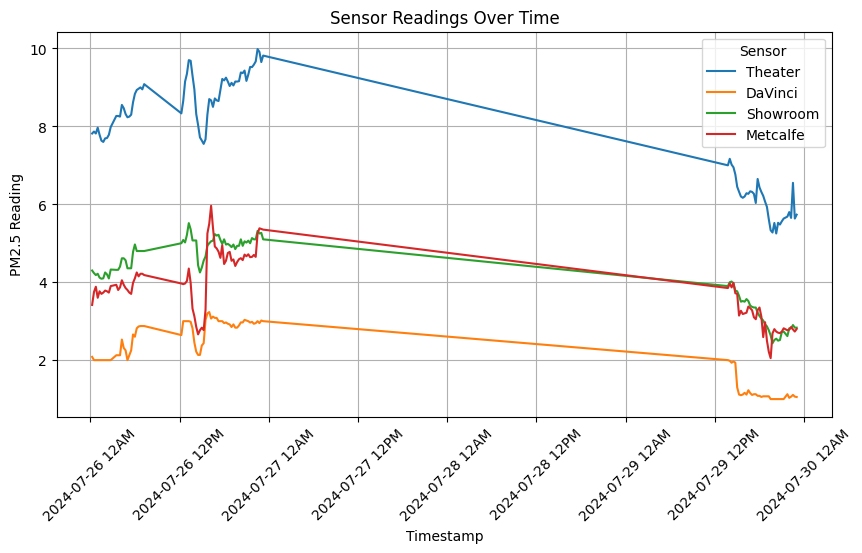

In [22]:
plt.figure(figsize=(10, 5))

# Loop through each site_num and plot its readings
for sensor in df['device_location'].unique():
    subset = df[df['device_location'] == sensor]
    plt.plot(subset['timestamp'], subset['avg_pm2.5'], label=sensor)

# Customize plot

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %I%p'))
plt.title('Sensor Readings Over Time')
plt.xlabel('Timestamp')
plt.xticks(rotation=45)

plt.ylabel('PM2.5 Reading')
plt.legend(title='Sensor')
plt.grid(True)

plt.show()


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 436 entries, 1 to 186
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp        436 non-null    datetime64[ns]
 1   avg_db           436 non-null    float64       
 2   avg_rh           436 non-null    float64       
 3   avg_lux          436 non-null    float64       
 4   avg_pm1          436 non-null    float64       
 5   avg_pm4          436 non-null    float64       
 6   avg_voc          436 non-null    float64       
 7   avg_eco2         436 non-null    float64       
 8   avg_pm10         436 non-null    float64       
 9   avg_temp         436 non-null    float64       
 10  avg_pm2.5        436 non-null    float64       
 11  avg_wynd_score   436 non-null    float64       
 12  device_id        436 non-null    object        
 13  device_location  436 non-null    object        
 14  status           436 non-null    int64         

In [24]:
df

,timestamp,avg_db,avg_rh,avg_lux,avg_pm1,avg_pm4,avg_voc,avg_eco2,avg_pm10,avg_temp,avg_pm2.5,avg_wynd_score,device_id,device_location,status
1,2024-07-26 00:15:00,61.666667,50.0,50.620000,5.466667,8.450000,31.633333,445.800000,9.200000,20.0,7.816667,95.0,HAL-007-d532860e,Theater,1
2,2024-07-26 00:30:00,59.016667,51.0,32.225000,5.500000,8.766667,20.650000,412.066667,9.416667,19.0,7.866667,95.0,HAL-007-d532860e,Theater,1
3,2024-07-26 00:45:00,58.783333,51.0,27.303333,5.333333,8.683333,13.266667,401.450000,9.716667,19.0,7.816667,95.0,HAL-007-d532860e,Theater,1
4,2024-07-26 01:00:00,58.283333,52.0,22.788333,5.416667,8.966667,16.850000,412.933333,9.616667,19.0,7.966667,95.0,HAL-007-d532860e,Theater,1
5,2024-07-26 01:15:00,58.183333,53.0,20.541667,5.450000,8.533333,16.450000,411.050000,9.250000,19.0,7.783333,95.0,HAL-007-d532860e,Theater,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2024-07-29 22:00:00,55.566667,48.0,502.213333,2.033333,3.583333,21.433333,414.266667,4.950000,20.0,2.783333,98.0,HAL-007-470dd483,Metcalfe,1
183,2024-07-29 22:15:00,57.850000,47.0,321.738333,2.050000,3.683333,23.783333,419.250000,5.016667,21.0,2.850000,97.0,HAL-007-470dd483,Metcalfe,1
184,2024-07-29 22:30:00,56.288462,46.0,418.278846,2.057692,3.750000,22.769231,413.153846,5.076923,21.0,2.788462,97.0,HAL-007-470dd483,Metcalfe,1
185,2024-07-29 22:45:00,54.650000,49.0,483.696667,2.050000,3.650000,18.666667,403.600000,4.966667,19.0,2.733333,98.0,HAL-007-470dd483,Metcalfe,1


In [25]:
# FEATURES 
FEATURES = ['device_location', 'timestamp', 'avg_pm2.5', 'status']
columns_to_drop = set(df.columns) - set(FEATURES)
columns_to_drop


{'avg_db',
 'avg_eco2',
 'avg_lux',
 'avg_pm1',
 'avg_pm10',
 'avg_pm4',
 'avg_rh',
 'avg_temp',
 'avg_voc',
 'avg_wynd_score',
 'device_id'}

In [26]:
#df = df.dropna()
df = df.rename(columns={"avg_pm2.5":"pm2_5_avg"})

In [27]:
#df['timestamp'] = pd.to_datetime(df['timestamp'])
#df['year'] = df['timestamp'].dt.year
#df['month'] = df['timestamp'].dt.month
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['dayoftheyear'] = df['timestamp'].dt.dayofyear

In [28]:
SENSOR_COLUMN = 'device_location' # PARAM2

In [29]:
distinctStations = df[SENSOR_COLUMN].unique() 
stationsNumber = distinctStations.shape[0]
print(f"There are {stationsNumber} distinct stations: " + str(distinctStations))
for stationID in distinctStations:
    currentStationNumberRows = df[df[SENSOR_COLUMN] == stationID].shape[0]
    print(f"Station {stationID} has {currentStationNumberRows} elements")

There are 4 distinct stations: ['Theater' 'DaVinci' 'Showroom' 'Metcalfe']
Station Theater has 109 elements
Station DaVinci has 109 elements
Station Showroom has 109 elements
Station Metcalfe has 109 elements


In [30]:
DATE_COLUMN = 'timestamp' # PARAM3 

In [31]:
dataStartDate = sorted(df[DATE_COLUMN])[0]
dataEndDate = sorted(df[DATE_COLUMN])[-1]
print(f"Dataset has data from {dataStartDate} to {dataEndDate}")

Dataset has data from 2024-07-26 00:15:00 to 2024-07-29 23:00:00


In [32]:
df["device_location"].unique()

array(['Theater', 'DaVinci', 'Showroom', 'Metcalfe'], dtype=object)

In [33]:
locations_placementIds = {
    'DaVinci' : 100,
    'Metcalfe' : 101,
    'Showroom' : 102,
    'Theater' : 103
}

In [34]:
df["placement_id"] = df["device_location"].map(locations_placementIds)

In [35]:
df = df.drop(columns={"device_location"})

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 436 entries, 1 to 186
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       436 non-null    datetime64[ns]
 1   avg_db          436 non-null    float64       
 2   avg_rh          436 non-null    float64       
 3   avg_lux         436 non-null    float64       
 4   avg_pm1         436 non-null    float64       
 5   avg_pm4         436 non-null    float64       
 6   avg_voc         436 non-null    float64       
 7   avg_eco2        436 non-null    float64       
 8   avg_pm10        436 non-null    float64       
 9   avg_temp        436 non-null    float64       
 10  pm2_5_avg       436 non-null    float64       
 11  avg_wynd_score  436 non-null    float64       
 12  device_id       436 non-null    object        
 13  status          436 non-null    int64         
 14  hour            436 non-null    int32         
 15  minute     

In [37]:
df_selected = df[['timestamp', 'pm2_5_avg', 'status', 'placement_id']]
df_pivoted = df_selected.pivot(index='timestamp', columns='placement_id')

df_pivoted.columns = [f"{col}_{pid}" for col, pid in df_pivoted.columns]
df_pivoted.reset_index(inplace=True)

In [38]:
df_pivoted

,timestamp,pm2_5_avg_100,pm2_5_avg_101,pm2_5_avg_102,pm2_5_avg_103,status_100,status_101,status_102,status_103
0,2024-07-26 00:15:00,2.083333,3.416667,4.300000,7.816667,1,1,1,1
1,2024-07-26 00:30:00,2.000000,3.750000,4.233333,7.866667,1,1,1,1
2,2024-07-26 00:45:00,2.000000,3.883333,4.183333,7.816667,0,1,1,1
3,2024-07-26 01:00:00,2.000000,3.600000,4.216667,7.966667,0,1,1,1
4,2024-07-26 01:15:00,2.000000,3.766667,4.116667,7.783333,1,1,1,1
...,...,...,...,...,...,...,...,...,...
104,2024-07-29 22:00:00,1.031250,2.783333,2.816667,5.800000,1,1,1,1
105,2024-07-29 22:15:00,1.062500,2.850000,2.816667,5.650000,1,1,1,1
106,2024-07-29 22:30:00,1.107143,2.788462,2.900000,6.550000,1,1,1,1
107,2024-07-29 22:45:00,1.062500,2.733333,2.833333,5.633333,1,1,1,1


In [39]:
df.shape[0] == df_pivoted.shape[0] * 4

True

In [40]:
df = df_pivoted

In [41]:
df = df.rename(columns={"timestamp": "Date", 
                   "placement_id": "Site Num"})
df = df.sort_values(['Date'])

In [42]:
df.to_csv(DATA_FOLDER_CACHE + "WESCO.csv")

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           109 non-null    datetime64[ns]
 1   pm2_5_avg_100  109 non-null    float64       
 2   pm2_5_avg_101  109 non-null    float64       
 3   pm2_5_avg_102  109 non-null    float64       
 4   pm2_5_avg_103  109 non-null    float64       
 5   status_100     109 non-null    int64         
 6   status_101     109 non-null    int64         
 7   status_102     109 non-null    int64         
 8   status_103     109 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 7.8 KB
